# 方策反復法(policy iteration)の考え方を迷路問題を用いて確認する

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from google.colab import files
    print('Google Colab. 上での実行です')
    print('「ファイルを選択」から、notebook/commonフォルダのmeiro.pyを選択し、アップロードしてください')
    print('===========')
    files.upload()
    !mkdir common
    !mv *.py ./common
except:
    print('ローカル環境での実行です')


from common.meiro import Environment

Google Colab. 上での実行です
「ファイルを選択」から、notebook/commonフォルダのmeiro.pyを選択し、アップロードしてください


Saving meiro.py to meiro.py


### [参考]

In [2]:
# <valueが最大になるkeyを取得する方法>

# dictの定義
action_value_dict = {"a":1, "b":2, "c":3}

# dictのgetメソッドは、引数に指定したkeyに対応するvalueを返してくれる
print(action_value_dict.get("b"))

# dictのgetメソッドをmaxのkey引数に指定することで、valueが最大となるkeyを取得することができる
max_ = max(action_value_dict, key=action_value_dict.get)
print(max_)

2
c


In [5]:
class Planner():

    def __init__(self, env):
        self.env = env
        self.log = []

    def initialize(self):
        """
        初期化メソッド
        """
        # 環境の初期化
        self.env.reset()

    def plan(self, gamma=0.9, threshold=0.0001):
        """
        planメソッドの実態は、このクラスを継承するクラスに記述する
        """
        raise Exception("Planner have to implements plan method.")

    def transitions_at(self, state, action):
        """
        行動確率, 次の状態, 報酬を順番に返すメソッド
        """
        dic_transition_probs = self.env.calc_transit_prob(state, action)
        for next_state, prob in dic_transition_probs.items():
            reward, _ = self.env.reward_func(next_state)
            yield prob, next_state, reward # 順番にreturnする(イテレータ)

    def dict_to_array(self, state_reward_dict):
        """
        dict形式を2次元配列形式に変換するメソッド
        """
        grid = np.zeros((self.env.row_length, self.env.col_length))
        for s in state_reward_dict:
            grid[s.row, s.col] = state_reward_dict[s]

        return grid
    

class PolicyIterationPlanner(Planner):
    """
    方策反復法を用いて、価値と方策を更新していくためのクラス
    """
    def __init__(self, env):
        
        # Plannerクラスの__init__メソッドを実行する
        super().__init__(env)
        
        self.policy = {}

    def initialize(self):
        """
        初期化メソッド
        """
        # Plannerクラスのinitializeメソッドを実行する
        super().initialize()
        
        self.policy = {}
        actions = self.env.actions
        states = self.env.states
        
        # 方策の初期化
        for s in states:
            self.policy[s] = {}
            for a in actions:
                self.policy[s][a] = 1 / len(actions) # すべての行動を等確率にする

    def estimate_by_policy(self, gamma, threshold, V):
        """
        方策を評価する(=価値を更新する）メソッド
        """

        while True:
            delta = 0
            
            for s in V.keys():
                """
                全ての状態をループ
                """
                expected_return = []
                
                for a in self.policy[s]:
                    """
                    ある状態においてとりうる行動をループ
                    """
                    action_prob = self.policy[s][a] # ある状態sにおいて行動aをとる確率
                    
                    if action_prob==0:
                        """
                        その行動aをとる確率が0であれば計算する意味がないのでスキップ
                        """
                        continue
                        
                    r = 0
                    for prob, next_state, reward in self.transitions_at(s, a):
                        """
                        ある状態sにおいてある行動aをとった場合のとりうるnext_stateのループ
                        """
                        # ある行動aをとる確率 * ある状態sにおいて行動aをとった場合に次の状態next_stateになる確率 * 期待収益
                        r += action_prob * prob * (reward + gamma * V[next_state])
                        
                    expected_return.append(r)
                    
                # 　expected_returnを合計することで、すべてのとりうる行動aに対する期待値になる
                value = sum(expected_return) 
                delta = max(delta, abs(value - V[s])) # 変化量
                V[s] = value # 価値の更新
                
            # 終了判定
            if delta < threshold:
                break

        return V

    def plan(self, gamma=0.9, threshold=0.00001):
        """
        各セルの価値を求めるメソッド
        """       
        # 初期化
        self.initialize()
        states = self.env.states
        actions = self.env.actions

        # 価値Vの初期化
        V = {}
        for s in self.env.states:
            V[s] = 0
            
            
        def take_max_action(action_value_dict):
            """
            valueが最大になるkeyを返す関数
            """
            return max(action_value_dict, key=action_value_dict.get)

        
        # 価値を更新するループ
        while True:

            # 終了判定フラグの初期化
            update_stable = True
            
            # 方策を評価する(=価値を更新する）
            V = self.estimate_by_policy(gamma, threshold, V)

            for s in states:
                """
                すべての状態をループ
                """
                # ある状態sにおいて確率が最大になる行動を求める
                policy_action = take_max_action(self.policy[s]) # 方策基準で選ばれた行動

                # ある状態sにおいて期待収益を最大にする行動を求める
                action_returns = {}
                for a in actions:
                    """
                    すべての行動をループ
                    """
                    r = 0
                    
                    for prob, next_state, reward in self.transitions_at(s, a):
                        """
                        ある状態sにおいてある行動aをとった場合のとりうるnext_stateのループ
                        """
                        # そのnext_stateをとる確率 * 収益
                        r += prob * (reward + gamma * V[next_state])
                        
                    action_returns[a] = r
                best_action = take_max_action(action_returns) # 行動価値基準で選ばれた行動
                
                # 終了判定
                if policy_action != best_action:
                    # 方策によって決めた行動policy_actionと期待収益を最大にする行動が異なっている場合は継続する
                    update_stable = False

                # 方策を改善(更新)する
                for a in self.policy[s]:
                    """
                    ある状態sにおいてとりうる行動aのループ
                    """
                    # best_actionをとる確率を1にし、残りの確率を0にする
                    prob = 1 if a == best_action else 0
                    self.policy[s][a] = prob

            # 終了判定
            if update_stable:
                break

        # dict形式のVを2次元配列に変換する
        V_grid = self.dict_to_array(V)
        
        return V_grid

## 実行

In [6]:
import time
start = time.time()

# 迷路の条件を設定する
grid = np.array([[0,0,0,1],[0,9,0,-1],[0,0,0,0]])

# 環境をつくる
env = Environment(grid, move_prob=0.95)

# 方策反復法のオブジェクトをつくる( 方策反復法において、エージェントは不要 )
planner = PolicyIterationPlanner(env)

# 方策反復法を実行する
V_result = planner.plan()

# 実行時間
elapsed_time = time.time() - start
print ("elapsed_time:{:.3f}".format(elapsed_time) + "[sec]")

elapsed_time:0.047[sec]


## 結果の可視化

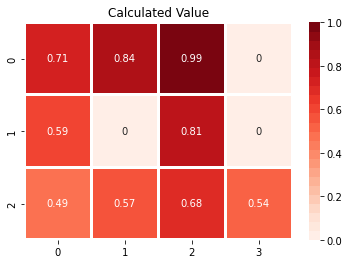

In [7]:
import seaborn as sns
sns.heatmap(V_result, annot=True, linewidths=2, vmin=0, vmax=1, cmap=sns.color_palette("Reds", 24))
plt.title("Calculated Value")
plt.show()